In [15]:
import pandas as pd
import networkx as nx
from pathlib import Path

prefix = 'data/umimematikucz-system_'

kc = pd.read_csv(Path(prefix + "kc.csv", ), sep=';', header=0, index_col=0)
follow = pd.read_csv(Path(prefix + "kc_follow.csv", ), sep=';', header=0, index_col=0)

G = nx.Graph()

G.add_nodes_from([(idx, {'name':name}) for idx, name in zip(kc.index, kc['name'])])
G.add_edges_from([(idx, parent) for idx, parent in zip(kc.index, kc['parent'])])
G.add_edges_from([(first, second) for first, second in follow[['kc1', 'kc2']].to_numpy()])
pos = nx.kamada_kawai_layout(G)

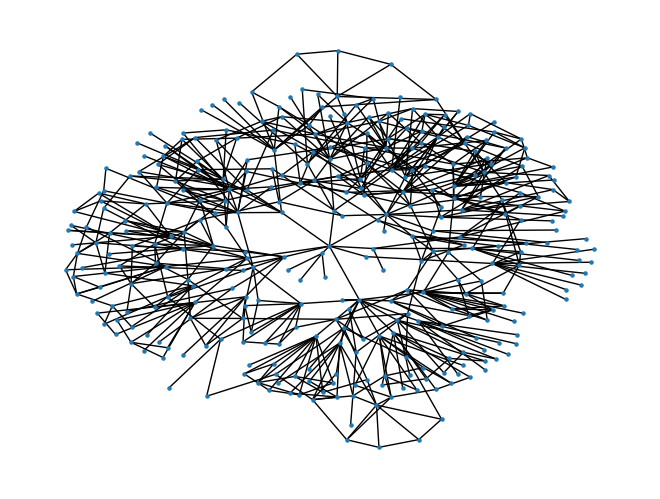

In [16]:
nx.draw(G, pos, width=1, node_size=5)

In [20]:
import plotly.graph_objects as go

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()